This code is based on:<br>
https://www.researchgate.net/profile/Wilson_Tolentino_Da_Silva2/publication/333982520_Time_Series_Prediction_A_Naive_Exploration/links/5d10ec94299bf1547c7afe08/Time-Series-Prediction-A-Naive-Exploration.pdf<br>
Adapted and updated by me.<br>
This program furthers the parametrization and modularization done in baseline_tolentino_base.

Este código está basado en:<br>
https://www.researchgate.net/profile/Wilson_Tolentino_Da_Silva2/publication/333982520_Time_Series_Prediction_A_Naive_Exploration/links/5d10ec94299bf1547c7afe08/Time-Series-Prediction-A-Naive-Exploration.pdf<br>
Adaptado y actualizado por mi.<br>
Este programa profundiza la parametrización y modularización de baseline_tolentino_base.

#### ANN Univariate Time Series Forecast
#### ANN Predicción de serie de tiempo de una variable
#### baseline_tolentino_base.jpnb
Sliding window/Ventana deslizante: 30<br>
Input scale/Escala de entrada: [-1, 1]<br>
Optimizer/Optimizador: adagrad<br>
Loss/Pérdida: LogCosh<br>
Data/Datos: 2000-01-03 - 2019-03-14<br>
Train Test split/Corte para prueba: 2016-01-01<br>
Hidden neurons/Capa oculta: 12 ReLU<br>
Output layer/Capa de salida: 1 Linear<br>
Epochs: 100<br>
Batch size/Tamaño de lote: 1

##### 1 Environment setup
##### 1 Configuración del ambiente

In [6]:
# Not needed on colab
# No hace falta en colab
%matplotlib inline
# import libraries and functions
# importar librerías y funciones
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from numpy.random import seed
from tensorflow.random import set_seed
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

##### 2 Download data
##### 2 Bajar los datos de la fuente
I downloaded the data from Yahoo finance and prepared the file baseline_tolentino.csv with the same data as the original thesis.

Yo bajé los datos a mano y prepare el archivo baseline_tolentino.csv con los mismos datos usados en la tesis original.

In [7]:
path_to_downloaded_file = tf.keras.utils.get_file(
    "baseline_tolentino.csv",
    "https://raw.githubusercontent.com/jmacostap/webstore/master/"+
    "baseline_tolentino.csv",
    cache_dir="/content",
    )

335872/328946 [==============================] - 0s 0us/step


##### 3 Data Preparation
##### 3 Preparación de los datos

In [8]:
# load data into a Pandas dataframe
# cargar los datos en un dataframe de Pandas
df = pd.read_csv(path_to_downloaded_file)
print(len(df), "lines read")

4829 lines read


In [9]:
# save the split point before dropping the Date column
# salva el punto de corte antes de borrar la columna de fecha
split = df[df['Date'].str.match('2016-01-04')].index.values[0]
split

4025

In [10]:
# drop columns that will not be used
# eliminar columnas que no se van a usar
df.drop(['Date', 'Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)

##### 4 Data Pre-processing
##### 4 Prepocesamiento de datos

In [11]:
# split the data and convert to 2D Numpy Arrays for MinMaxScaler
# separar los datos y convertir a arreglos Numpy para MinMaxScaler
train = df.iloc[:split].values.reshape(-1,1)
test = df.iloc[split:].values.reshape(-1,1)

In [12]:
# scale data
# escalar los datos
scaler = MinMaxScaler(feature_range=(-1, 1))
# it must fit using only train data to avoid dataleak
# debe escalar usando solo la data de entrenamiento para evitar dataleak
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

##### 5 Definition of support functions
##### 5 Definición de funciones de soporte

###### 5.1 Data preparation in sliding windows
###### 5.1 Preparación de los datos en ventanas deslizantes

In [13]:
# prepare time series and targets for Keras
# preparar la serie de tiempo y los objetivos para Keras
def prepare_time_series(time_series, targets, window):
    """
    like tf.keras.preprocessing.sequence.TimeseriesGenerator
    except the batches
    time_series[0:window] -> targets[window]
    In the most basic case time_series and targets are the same array

    como tf.keras.preprocessing.sequence.TimeseriesGenerator
    excepto los lotes
    time_series[0:window] -> targets[window]
    En el caso más básico time_series and targets son el mismo arreglo
    """
    data_set_length = len(time_series) - window
    X = np.empty((data_set_length, window))
    Y = np.empty((data_set_length, 1))
    for i in range(data_set_length):
        X[i, :] = time_series[i:(i + window)]
        Y[i, 0] = targets[i + window]
    return X, Y

###### 5.2 Model definition and training
###### 5.2 Definición del modelo y entrenamiento

In [14]:
def create_ann(p, train_data):
    # prepare train and test data for Keras
    # prepara los datos para Keras
    X_train, y_train = prepare_time_series(
        train_data.flat, train_data.flat, p['window'])
    # ensure reproducibility
    # asegurar reproducibilidad
    np.random.seed(314159)
    tf.random.set_seed(1606691)

    ann = Sequential([Dense(units=p['neurons'],
                            input_dim=p['window'],
                            activation=p['activation']),
                      Dense(units=1, activation=p['output_activation'])])

    ann.compile(loss=p['loss'], optimizer=p['optimizer'])

    history = ann.fit(x=X_train,
                      y=y_train,
                      epochs=p['epochs'],
                      batch_size=p['batch_size'],
                      verbose=p['verbose'],
                      validation_split=0.0, # use all data for training
                      # usa todos los datos para entrenar
                      shuffle=p['shuffle'])
    
    return ann, history

###### 5.3 Model performance evaluation
###### 5.3 Evaluación de rendimiento del modelo

In [15]:
# show the ANN performance
# mostrar el rendimiento de la RNA
def display_ann(ann, history, window, train_data, test_data):

    X_train, y_train = prepare_time_series(
        train_data.flat, train_data.flat, p['window'])
    X_test, y_test = prepare_time_series(
        test_data.flat, test_data.flat, p['window'])

    ann_train_loss = ann.evaluate(x=X_train,
        y=y_train,
        batch_size=p['batch_size'])
    ann_test_loss = ann.evaluate(x=X_test,
        y=y_test,
        batch_size=p['batch_size'])
    y_train_pred = ann.predict(X_train)
    y_test_pred = ann.predict(X_test)

    # Show various scores
    # muestra varios puntajes
    print("ANN train {}: {}".format(p['loss'], ann_train_loss))
    print("ANN test {}: {}".format(p['loss'], ann_test_loss))
    print("R2 score of a trivial predictor on train data:\t{:0.8f}".format(r2_score(y_train[1:], y_train[:-1])))
    print("R2 score of a trivial predictor on test data:\t{:0.8f}".format(r2_score(y_test[1:], y_test[:-1])))
    print("MSE of a trivial predictor on train data:\t{:0.8f}".format(mean_squared_error(y_train[1:], y_train[:-1])))
    print("MSE of a trivial predictor on test data:\t{:0.8f}".format(mean_squared_error(y_test[1:], y_test[:-1])))
    print("The R2 score on the Train set is:\t{:0.8f}".format(r2_score(y_train, y_train_pred)))
    print("The R2 score on the Test set is:\t{:0.8f}".format(r2_score(y_test, y_test_pred)))
    print("MSE of the trained ANN on train data:\t{:0.8f}".format(mean_squared_error(y_train, y_train_pred)))
    print("MSE of the trained ANN on test data:\t{:0.8f}".format(mean_squared_error(y_test, y_test_pred)))

    # show the data in a graph
    # muestra los datos en una gráfica
    plt.figure(figsize=(10, 6))
    plt.plot(range(split), train_data, label='train')
    plt.plot(range(split, len(df)), test_data, label='test')
    plt.plot(range(window, window + len(y_train_pred)),
             y_train_pred, label='trained')
    plt.plot(range(window + split, window + split + len(y_test_pred)),
             y_test_pred, label='test prediction')
    plt.title('Original data and ANN predictions')
    plt.xlabel('Observation')
    plt.ylabel('S&P500 Close Daily scaled')
    #    plt.legend()
    plt.show()

    # graph Train and Validation loss evolution
    # gráfico de evolución del entrenamiento y validación
    skip = 2  # Avoid autoscale issues
    # si los primeros valores son muy altos se pueden eliminar del gráfico
    # para evitar que afecten la escala
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'][skip:], 'g', label='Training loss')
    # plt.plot(history.history['val_loss'][skip:], 'b', label='Validation loss')
    plt.title('Loss evolution during training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

##### 6 Hyperparameters definition
##### 6 Definición de hiperparámetros

In [16]:
# define hyperparameters
# define los hiperparámetros
p = {
     "window": 30,
     "neurons": 12,
     "activation": "relu",  # for the hidden layer/para la capa oculta
     # could be/puede ser relu, sigmoid, softmax, softplus, softsign, tanh,
     # selu, elu, exponential, or linear 
     "output_activation": "linear",  # for the output layer/capa de salida
     "loss": "logcosh",  # could be/puede ser mse, mae, msle, cs, huber,
     # or logcosh
     "optimizer": "adagrad",  # could be/puede ser sgd, rmsprop, adam, adadelta,
     # adagrad, adamax, nadam, or ftrl
     # o una instancia de una clase con parámetros
     # or a class instance with parameters like
     # tf.keras.optimizers.SGD(
     #    learning_rate=0.3,
     #    momentum=0.2,
     #    nesterov=False),
     "epochs": 100,  # training epochs/épocas de entrenamiento
     "batch_size": 1,
     "shuffle": False,  # the training data/mezclar los datos de entrenamiento
     "verbose": 2,  # verbose training/entrenamiento verboso
    }

##### 7 Try the ANN
##### 7 Probar la RNA

In [17]:
# create the ANN
# crear la RNA
ann, history = create_ann(p, train_scaled)

Epoch 1/100
3995/3995 - 3s - loss: 0.0068
Epoch 2/100
3995/3995 - 2s - loss: 0.0020
Epoch 3/100
3995/3995 - 2s - loss: 0.0019
Epoch 4/100
3995/3995 - 2s - loss: 0.0018
Epoch 5/100
3995/3995 - 2s - loss: 0.0017
Epoch 6/100
3995/3995 - 2s - loss: 0.0016
Epoch 7/100
3995/3995 - 2s - loss: 0.0015
Epoch 8/100
3995/3995 - 2s - loss: 0.0015
Epoch 9/100
3995/3995 - 2s - loss: 0.0014
Epoch 10/100
3995/3995 - 2s - loss: 0.0014
Epoch 11/100
3995/3995 - 2s - loss: 0.0014
Epoch 12/100
3995/3995 - 2s - loss: 0.0013
Epoch 13/100
3995/3995 - 2s - loss: 0.0013
Epoch 14/100
3995/3995 - 2s - loss: 0.0013
Epoch 15/100
3995/3995 - 2s - loss: 0.0012
Epoch 16/100
3995/3995 - 2s - loss: 0.0012
Epoch 17/100
3995/3995 - 2s - loss: 0.0012
Epoch 18/100
3995/3995 - 2s - loss: 0.0012
Epoch 19/100
3995/3995 - 2s - loss: 0.0012
Epoch 20/100
3995/3995 - 2s - loss: 0.0012
Epoch 21/100
3995/3995 - 2s - loss: 0.0011
Epoch 22/100
3995/3995 - 2s - loss: 0.0011
Epoch 23/100
3995/3995 - 2s - loss: 0.0011
Epoch 24/100
3995/39

774/774 [==============================] - 1s 727us/step - loss: 0.0012
ANN train logcosh: 0.0008075728546828032
ANN test logcosh: 0.0012427523033693433
R2 score of a trivial predictor on train data:	0.99784747
R2 score of a trivial predictor on test data:	0.99449970
MSE of a trivial predictor on train data:	0.00042606
MSE of a trivial predictor on test data:	0.00075296
The R2 score on the Train set is:	0.99182529
The R2 score on the Test set is:	0.98184631
MSE of the trained ANN on train data:	0.00161765
MSE of the trained ANN on test data:	0.00249491


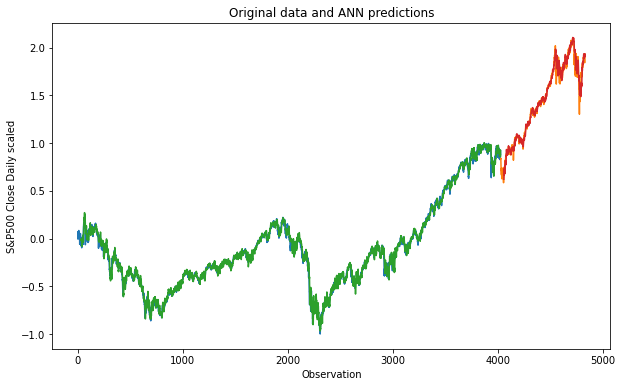

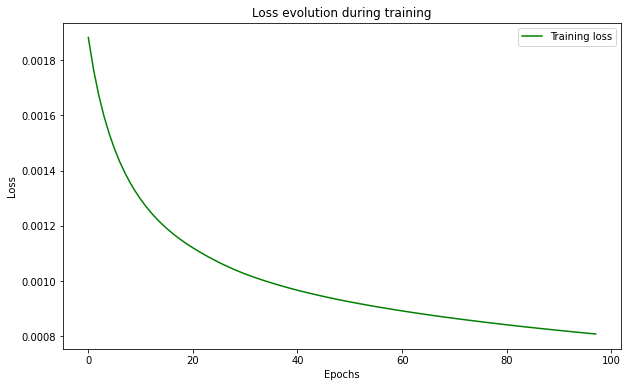

In [18]:
# evaluate the ANN
# evaluar la RNA
display_ann(ann, history, p['window'], train_scaled, test_scaled)